# Clustering Project
## Objective : Identify Patient Risk Profile by using Clustering
## Data Source :  /kaggle/input/heart-disease-dataset



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.cluster import KMeans ,AgglomerativeClustering
import seaborn as sns
from sklearn.decomposition import PCA
import kagglehub
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [ ]:
path = kagglehub.dataset_download("johnsmith88/heart-disease-dataset")
print("source of the files:", path)


source of the files: /kaggle/input/heart-disease-dataset


## Feature Description

<table>
  <thead>
    <tr>
      <th>Feature</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr><td><code>age</code></td><td>Person’s age</td></tr>
    <tr><td><code>sex</code></td><td>Gender (1 = male, 0 = female)</td></tr>
    <tr><td><code>cp</code></td><td>Type of chest pain (rated from 0 to 3)</td></tr>
    <tr><td><code>trestbps</code></td><td>Blood pressure while resting (not active)</td></tr>
    <tr><td><code>chol</code></td><td>Cholesterol level (amount of fat in the blood)</td></tr>
    <tr><td><code>fbs</code></td><td>Is blood sugar high without eating? (1 = yes, 0 = no)</td></tr>
    <tr><td><code>restecg</code></td><td>Heart’s electrical signals at rest (test result)</td></tr>
    <tr><td><code>thalach</code></td><td>Highest heart rate reached during exercise</td></tr>
    <tr><td><code>exang</code></td><td>Did chest pain happen during exercise? (1 = yes, 0 = no)</td></tr>
    <tr><td><code>oldpeak</code></td><td>Change in heart activity during exercise (measured by a test)</td></tr>
    <tr><td><code>slope</code></td><td>Shape of heart signal line during exercise (normal or not)</td></tr>
    <tr><td><code>ca</code></td><td>Number of main heart vessels clearly seen in a scan (0 to 3)</td></tr>
    <tr><td><code>thal</code></td><td>Blood flow condition: 0 = normal, 1 = fixed problem, 2 = changeable problem</td></tr>
    <tr><td><code>target</code></td><td>Heart disease diagnosis (1 = has disease, 0 = no disease)</td></tr>
  </tbody>
</table>


#Uploading and Exploring Data

In [ ]:
file_path = os.path.join(path, 'heart.csv')
df = pd.read_csv(file_path)
df.head(5)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [ ]:
missign_values = df.isnull().sum()
print("check missing values\n",missign_values)
df.dropna(inplace=True)
print("after droping nulls \n",df.isnull().sum())


check missing values
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
after droping nulls 
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


Although there are no missing values in the current dataset, it is important to include the step of dropping null values in case new data is added or the dataset is updated in the future

In [ ]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())

723
0


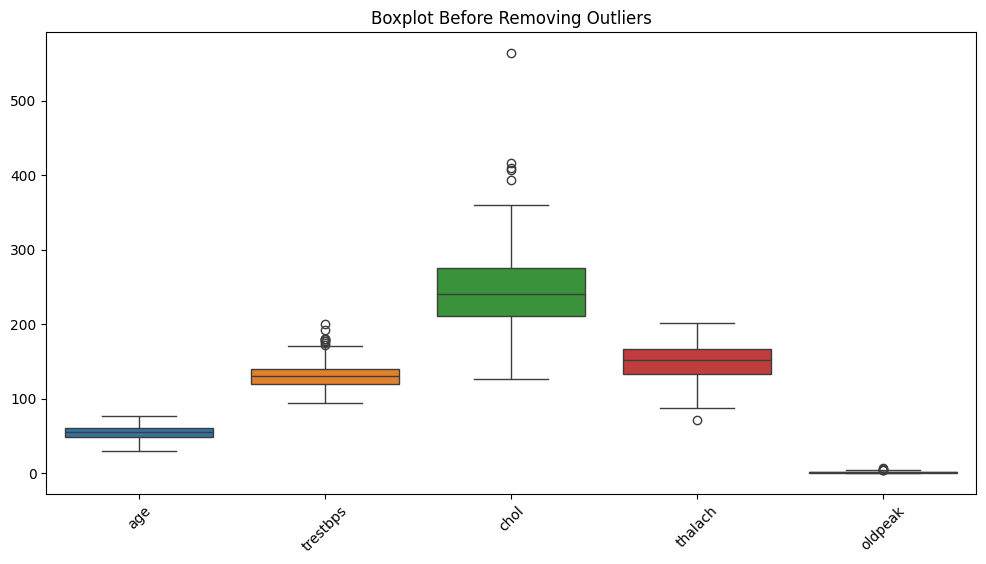

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[ ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']])
plt.title("Boxplot Before Removing Outliers")
plt.xticks(rotation=45)
plt.show()

### A deeper look at the outliers and what they represent.

## Checking outliers

In [ ]:
df[df['chol'] == df['chol'].max()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
158,67,0,2,115,564,0,0,160,0,1.6,1,0,3,1


# Data Processing
Based on the dataset overview and the boxplot visualization, it is evident that all features are numerical and there are no missing values. Therefore, there is no need for imputation or categorical encoding.

However, two key preprocessing steps are still necessary:

1- Outlier detection should be conducted, as certain features—such as cholesterol and resting blood pressure—contain extreme values that may distort clustering results.

2- Feature scaling is required to standardize the range of all variables, ensuring that no single feature disproportionately influences the distance calculations used by clustering algorithms.

In [ ]:
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
z_scores = np.abs(zscore(df[num_cols]))
df_clean = df[(z_scores < 2.5).all(axis=1)]

print("Original shape:", df.shape)
print("After removing outliers:", df_clean.shape)
print("Number of rows removed:", df.shape[0] - df_clean.shape[0])

Original shape: (302, 14)
After removing outliers: (281, 14)
Number of rows removed: 21


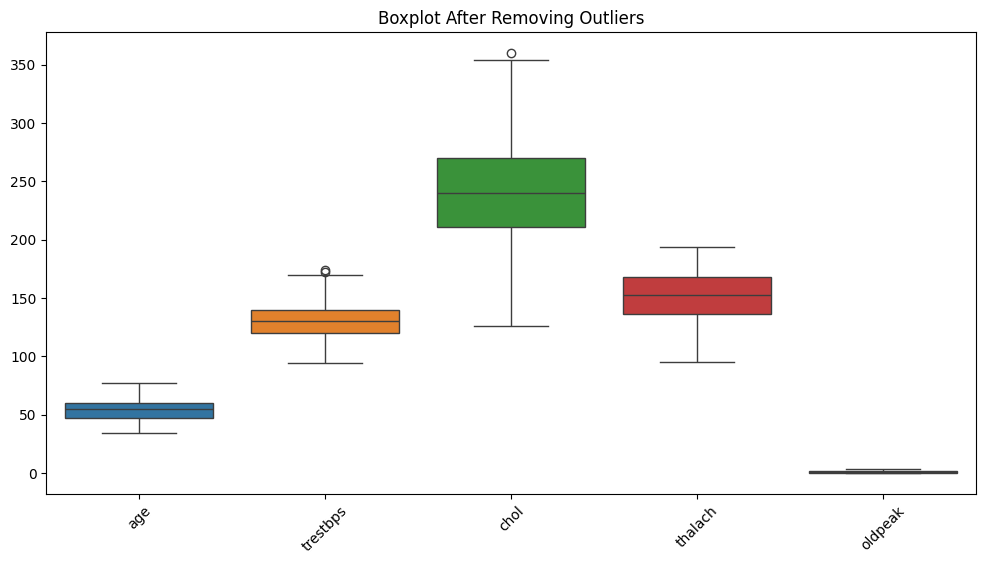

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean[num_cols])
plt.title("Boxplot After Removing Outliers")
plt.xticks(rotation=45)
plt.show()

Since the boxplot visualization after Z-score filtering still indicates the presence of outliers in trestbps—an additional outlier handling step was applied using the Interquartile Range (IQR) method. This approach removes values that lie significantly outside the middle 50% of the distribution, offering more robust filtering on a per-feature basis, especially for variables with non-normal or skewed distributions.

In [ ]:
df_clean = df.copy()
for col in num_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

print("Original shape:", df.shape)
print("After removing outliers using IQR:", df_clean.shape)
print("Number of rows removed:", df.shape[0] - df_clean.shape[0])

Original shape: (302, 14)
After removing outliers using IQR: (283, 14)
Number of rows removed: 19


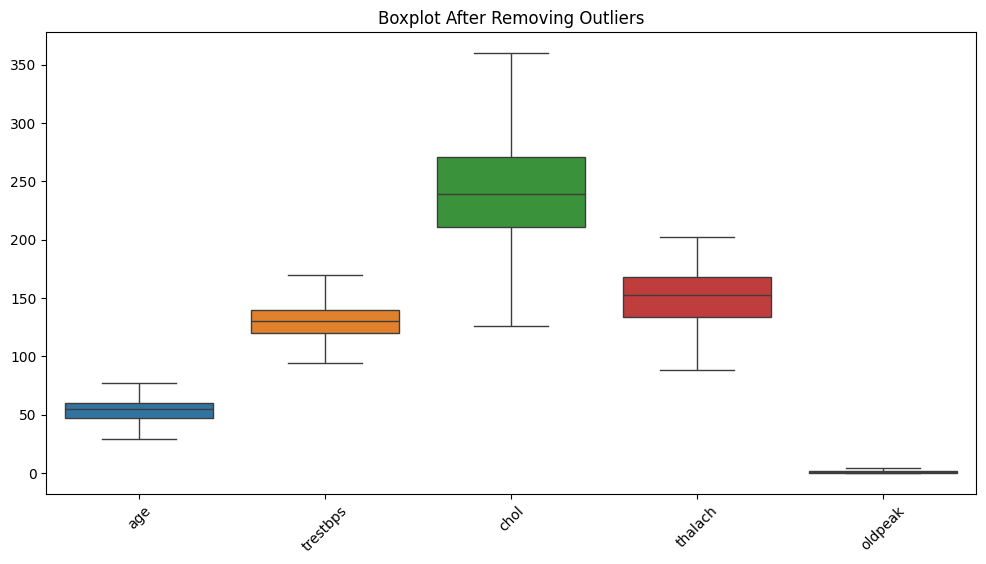

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean[num_cols])
plt.title("Boxplot After Removing Outliers")
plt.xticks(rotation=45)
plt.show()

To avoid distorting categorical or discrete variables, feature scaling was applied only to continuous numerical columns using StandardScaler. This ensures that distance-based clustering algorithms treat features equitably while preserving the interpretability of categorical data."



In [ ]:
cols_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

df_scaled = df_clean.copy()

scaler = StandardScaler()
df_scaled[cols_to_scale] = scaler.fit_transform(df_clean[cols_to_scale])

df = df_scaled.copy()
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,-0.224919,1,0,-0.317917,-0.680075,0,1,0.796365,0,0.046903,2,2,3,0
1,-0.115174,1,0,0.658608,-0.881981,1,0,0.222452,1,2.096513,0,0,3,0
2,1.750489,1,0,0.984117,-1.532566,0,1,-1.101964,1,1.608511,0,0,3,0
3,0.762785,1,0,1.179422,-0.881981,0,1,0.487335,0,-0.929101,2,1,3,0
4,0.872530,0,0,0.528405,1.159512,1,1,-1.940760,0,0.925307,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1.530999,0,2,-0.643426,-0.702509,0,0,-1.543436,0,0.534906,1,0,2,1
733,-1.102878,0,2,-1.424646,-2.272888,0,1,1.105396,0,-0.343498,1,0,2,1
739,-0.224919,1,0,-0.122612,0.284587,0,1,0.487335,1,-0.929101,2,1,3,0
843,0.543295,1,3,1.960642,0.688398,0,0,-1.101964,0,-0.929101,2,0,2,0


# Clustering Model Selection and Training

 **Clustering Goal: Identify Patient Risk Profiles**

We aim to group patients into clusters based on key health indicators to uncover hidden risk profiles for heart disease. This helps in designing targeted prevention and treatment strategies.

**Selected Features & Risk Relevance**

We chose the following features for clustering based on their known impact on heart disease:

Age ↑ → Older age = Higher risk

Cholesterol (chol) ↑ → High levels = Higher risk

Resting Blood Pressure (trestbps) ↑ → Elevated = Moderate risk

Max Heart Rate (thalach) ↓ → Lower rate = Higher risk

Oldpeak ↑ → More ST depression = Higher risk




In [ ]:
features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
X = df[features]


## K-means Clustring

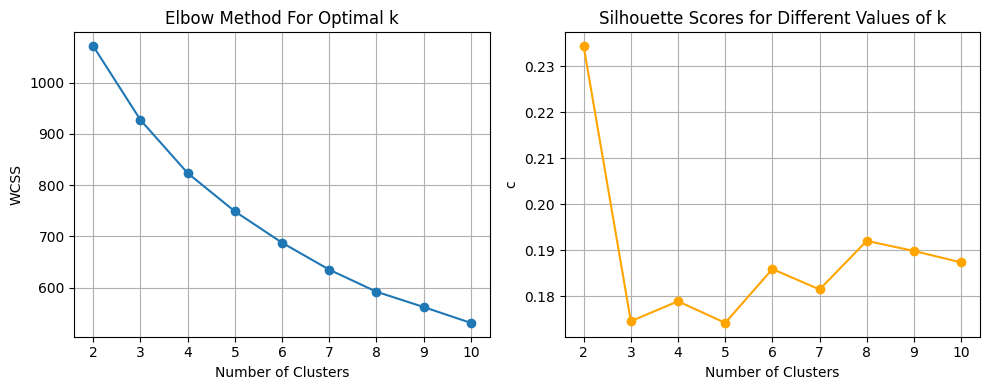

In [ ]:
wcss = []
silhoutte_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    wcss.append(kmeans.inertia_)
    sil_score = silhouette_score(X, cluster_labels)
    silhoutte_scores.append(sil_score)


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhoutte_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters')
plt.ylabel('c')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', max_iter=300, n_init=10, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

print("Cluster Sizes:")
print(df['cluster'].value_counts().sort_index())

Cluster Sizes:
cluster
0    92
1    74
2    62
3    55
Name: count, dtype: int64


Cluster Profiles (means of selected features):

          age  trestbps  chol  thalach  oldpeak
cluster                                        
0       -0.90     -0.19 -0.33     0.87    -0.60
1        0.53      0.55  0.87     0.07    -0.33
2        0.06     -0.85 -0.63    -0.52     0.05
3        0.73      0.54  0.09    -0.97     1.40


<Figure size 600x300 with 0 Axes>

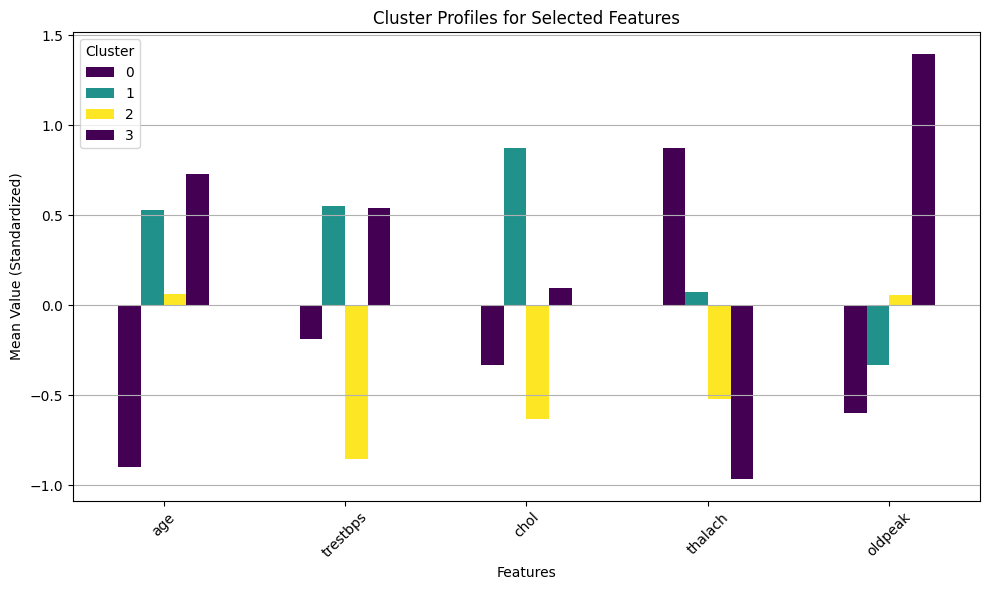

In [ ]:
import matplotlib.pyplot as plt

features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
cluster_profiles = df.groupby('cluster')[features].mean()

print("Cluster Profiles (means of selected features):\n")
print(cluster_profiles.round(2))

plt.figure(figsize=(6, 3))
colors = plt.cm.viridis(np.linspace(0, 1, k_optimal))
cluster_profiles.T.plot(kind='bar', color=colors, figsize=(10, 6))
plt.title('Cluster Profiles for Selected Features')
plt.ylabel('Mean Value (Standardized)')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



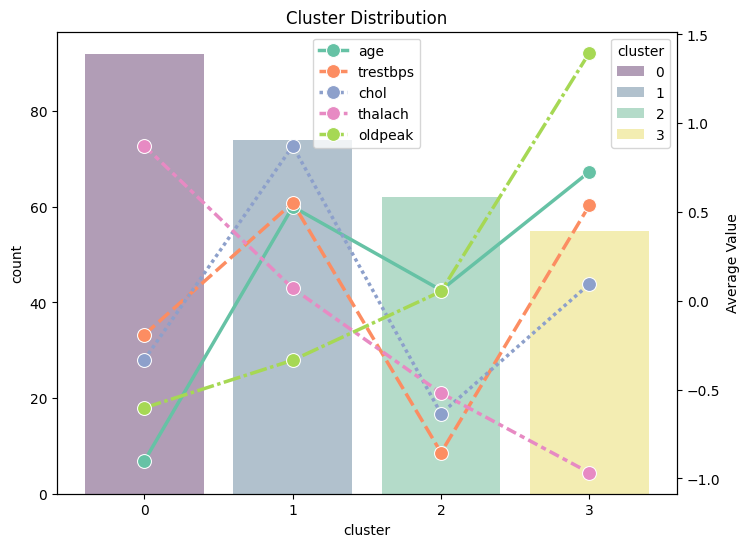

In [ ]:
cluster_counts = df['cluster'].value_counts()
feature_means = df.groupby('cluster')[features].mean()

fig, ax1 = plt.subplots(figsize=(8, 6))

sns.barplot(
    x=cluster_counts.index,
    y=cluster_counts.values,
    ax=ax1,
    hue=cluster_counts.index,
    alpha=0.4,
    palette='viridis'
)
ax1.set_ylabel('count')
ax1.set_title('Cluster Distribution')

ax2 = ax1.twinx()

sns.lineplot(
    data=feature_means,
    ax=ax2,
    palette='Set2',
    marker='o',
    linestyle='--',
    linewidth=2.5,
    markersize=10
)
ax2.set_ylabel('Average Value')

plt.show()


### Cluster Overview

**Cluster 3 (High Risk)**
- **Characteristics:**
  - Higher age, higher cholesterol, elevated resting BP.
  - Low max heart rate (thalach), high oldpeak.
- **Risk Implication:**
  - Severe risk profile: older patients with poor exercise tolerance and high cardiac stress.

---

**Cluster 2 (Moderate Risk)**
- **Characteristics:**
  - Lower cholesterol and BP, moderate age.
- **Risk Implication:**
  - Balanced profile but still some cardiovascular concerns.

---

**Cluster 1 (Moderate Risk)**
- **Characteristics:**
  - Higher age, cholesterol, and BP; moderate thalach; low oldpeak.
- **Risk Implication:**
  - Moderate-high risk—elevated vitals but acceptable fitness.

---

**Cluster 0 (Low Risk)**
- **Characteristics:**
  - Younger, low cholesterol and BP, high thalach, low oldpeak.
- **Risk Implication:**
  - Healthy, low-risk patients with good fitness.

---

## Practical Implications
The clustering results provide valuable insights into distinct patient risk profiles based on health indicators. These profiles can guide targeted prevention strategies, health monitoring, and personalized treatments. Understanding these patterns helps healthcare providers identify patients who need more immediate intervention and manage care more effectively.


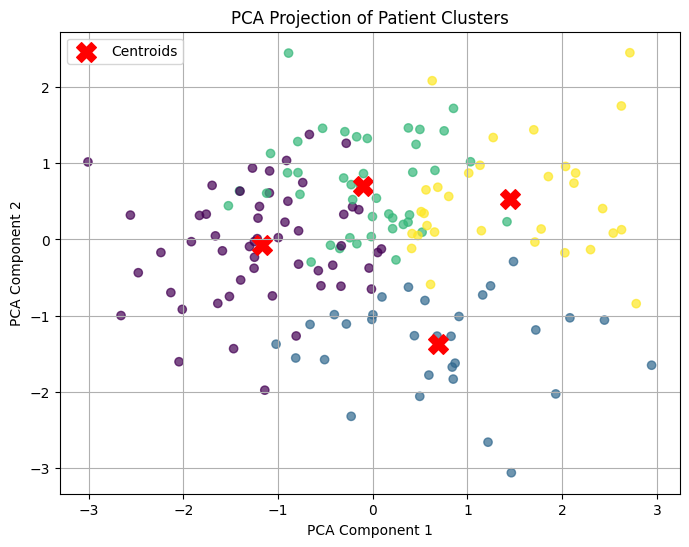

In [ ]:
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X.values)

centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', alpha=0.7)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
            c='red', marker='X', s=200, label='Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection of Patient Clusters')
plt.legend()
plt.grid(True)
plt.show()


# Agglomerative (Hierarchical) Clustering

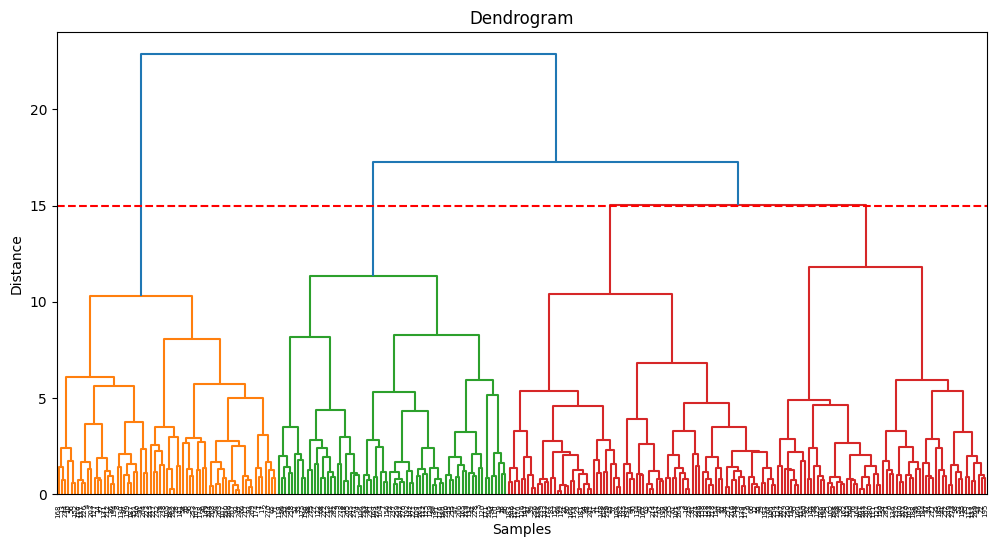

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
linked = linkage(X, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked)
plt.axhline(y=15, color='red', linestyle='--')
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

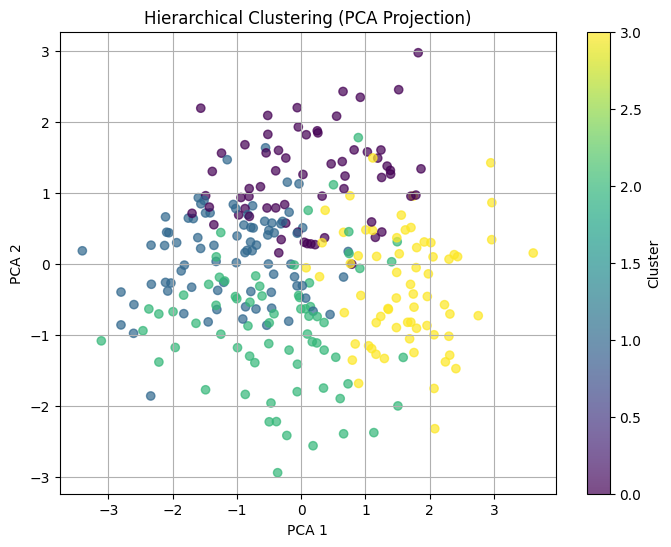

In [ ]:
model = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels = model.fit_predict(X)
df['AgglomerativeCluster']= labels

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title('Hierarchical Clustering (PCA Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


# Evaluation and Comparison

**Silhouette Score:** measures how close each point is to its own cluster vs. others.Range [-1,1] higher is better.

**Calinski-Harabasz:** Ratio of between-cluster variance to within-cluster variance. t ranges  [0,∞] Higher is better



In [ ]:
print("Silhouette Score for k-means:", silhouette_score(X, df['cluster']))
print("Calinski-Harabasz for k-means:", calinski_harabasz_score(X, df['cluster']))
print("\n\nSilhouette Score for AgglomerativeCluster:", silhouette_score(X, df['AgglomerativeCluster']))
print("Calinski-Harabasz for AgglomerativeCluster:", calinski_harabasz_score(X, df['AgglomerativeCluster']))


Silhouette Score for k-means: 0.17891067046645043
Calinski-Harabasz for k-means: 66.81476253169411


Silhouette Score for AgglomerativeCluster: 0.14244904654164675
Calinski-Harabasz for AgglomerativeCluster: 54.68844499098933


#Clustring By Two Features

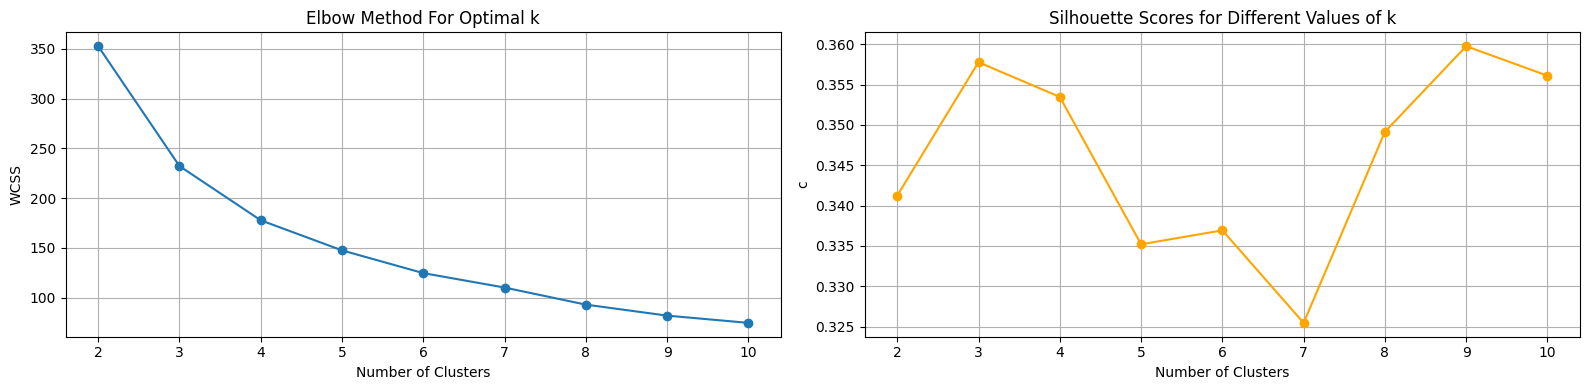

In [ ]:
features = ['age', 'chol']
X2 = df[features]
wcss = []
silhoutte_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X2)
    wcss.append(kmeans.inertia_)
    sil_score = silhouette_score(X2, cluster_labels)
    silhoutte_scores.append(sil_score)


plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhoutte_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters')
plt.ylabel('c')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', max_iter=300, n_init=10, random_state=42)
df['cluster_using_2'] = kmeans.fit_predict(X2)

# Display the number of samples in each cluster
print("Cluster Sizes:")
print(df['cluster_using_2'].value_counts().sort_index())

Cluster Sizes:
cluster_using_2
0     91
1    103
2     89
Name: count, dtype: int64


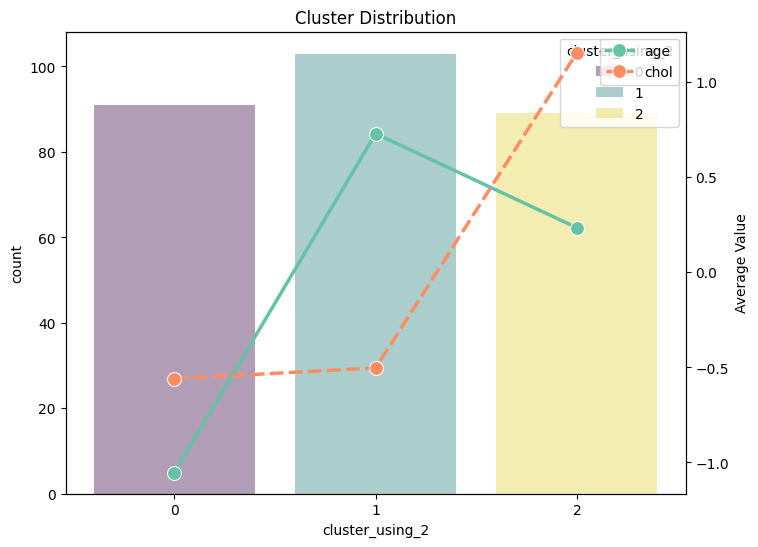

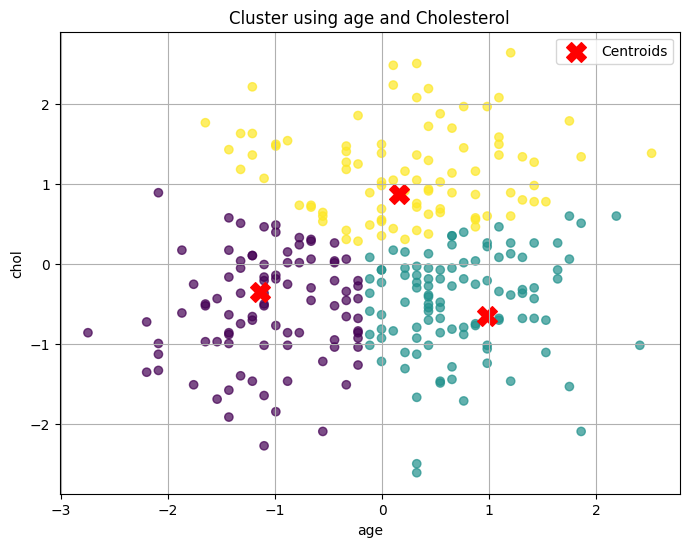

In [ ]:
cluster_counts = df['cluster_using_2'].value_counts()
feature_means = df.groupby('cluster_using_2')[features].mean()

fig, ax1 = plt.subplots(figsize=(8, 6))

sns.barplot(
    x=cluster_counts.index,
    y=cluster_counts.values,
    ax=ax1,
    hue=cluster_counts.index,
    alpha=0.4,
    palette='viridis'
)
ax1.set_ylabel('count')
ax1.set_title('Cluster Distribution')

ax2 = ax1.twinx()

sns.lineplot(
    data=feature_means,
    ax=ax2,
    palette='Set2',
    marker='o',
    linestyle='--',
    linewidth=2.5,
    markersize=10
)
ax2.set_ylabel('Average Value')

plt.figure(figsize=(8, 6))
plt.scatter(X2['age'], X2['chol'], c=df['cluster_using_2'], cmap='viridis', alpha=0.7)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
            c='red', marker='X', s=200, label='Centroids')
plt.xlabel('age')
plt.ylabel('chol')
plt.title('Cluster using age and Cholesterol')
plt.legend()
plt.grid(True)
plt.show()



**cluster 0:** Younger, Low Cholesterol

**cluster 1:** 	older	, Low cholesterol

**cluster 2:** Middle-aged, High cholesterol

# Evaluation

In [ ]:
print("Silhouette Score for cluster_using_2:", silhouette_score(X2, df['cluster_using_2']))
print("Calinski-Harabasz for cluster_using_2:", calinski_harabasz_score(X2, df['cluster_using_2']))

Silhouette Score for cluster_using_2: 0.35776348953828124
Calinski-Harabasz for cluster_using_2: 201.2738142166527
